In [288]:
import numpy as np
import pandas as pd
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import StandardScaler #normalisation
from sklearn.model_selection import train_test_split #train_test_split
import matplotlib.pyplot as plt

In [289]:
df = pd.read_csv('optdigits.csv')
# stratified_sample.drop('Unnamed: 0', axis = 1)
df

,Dim1,Dim2,Dim3,Dim4,Dim5,Dim6,Dim7,Dim8,Dim9,Dim10,...,Dim56,Dim57,Dim58,Dim59,Dim60,Dim61,Dim62,Dim63,Dim64,Class
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
3819,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
3820,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
3821,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [290]:
df['Class']. value_counts()

Class
1    389
3    389
7    387
4    387
9    382
2    380
8    380
6    377
0    376
5    376
Name: count, dtype: int64

In [291]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

# Assuming "Revenue" is the target variable and the rest are features
features = df.drop("Class", axis=1)  # Exclude the target variable from features

# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(features, df["Class"], random_state=1, test_size=0.20, stratify=df["Class"])


In [292]:
# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)

In [293]:
# Best Matching Unit search
def winning_neuron(data, t, som):
  winner = np.unravel_index(np.argmin(np.linalg.norm(som - data[t], axis=-1)), som.shape[:2])
  return winner

In [294]:
# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_distance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_distance)
  return learning_rate, neighbourhood_range

In [295]:
# hyperparameters

num_neurons = int(5 * np.sqrt(df.shape[0]))
num_rows = int(np.sqrt(num_neurons))
num_cols = int(np.sqrt(num_neurons))
# num_rows = 30
# num_cols = 30
max_m_distance = 4
max_learning_rate = 0.5
max_steps = 500*num_rows*num_cols
# max_steps = 500000
num_dims = df.shape[1]-1

In [296]:
print("Number of neurons: ", num_neurons)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)
print("Max Steps: ", max_steps)
print("Number of dimensions: ", num_dims)
print("Number of training samples: ", train_X.shape[0])

Number of neurons:  309
Number of rows:  17
Number of columns:  17
Max Steps:  144500
Number of dimensions:  64
Number of training samples:  3058


In [297]:
np.random.seed(30)
som = np.random.rand(num_rows,num_cols,num_dims)

train_X_norm = StandardScaler().fit_transform(train_X)

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packa

In [298]:
# Training
for step in range(max_steps):
  if (step+1) % 100000 == 0:
    print('Step: ', step+1)
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_distance)

  t = np.random.randint(0,train_X_norm.shape[0])
  winner = winning_neuron(train_X_norm, t, som)
  update_mask = np.where(distance.cdist(np.array(winner).reshape(1,2), np.indices(som.shape[:2]).reshape(2,-1).T, metric='cityblock').reshape(som.shape[:2]) <= neighbourhood_range)
  som[update_mask] = som[update_mask] + learning_rate * (train_X_norm[t] - som[update_mask])

Step:  100000


In [299]:
# Collecting labels for each neuron
label_data = train_y.to_numpy()
list_map = np.empty((num_rows,num_cols),dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    list_map[row][col] = []

for t in range(train_X_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print('Step: ', t+1)
  winner = winning_neuron(train_X_norm, t, som)
  list_map[winner[0]][winner[1]].append(label_data[t])

import numpy as np
from scipy.spatial.distance import cdist

# ... (previous code)

# Assigning labels to each neuron
label_map = np.zeros((num_rows, num_cols), dtype=int)
for row in range(num_rows):
    for col in range(num_cols):
        label_list = list_map[row][col]

        if len(label_list) == 0:
            # If no labels are assigned to the current neuron, find the label of the closest labeled neuron
            labeled_neurons = np.argwhere(label_map != 0)

            if len(labeled_neurons) > 0:
                distances = cdist(np.array([(row, col)]), labeled_neurons)
                closest_neuron_index = np.argmin(distances)
                closest_neuron_indices = labeled_neurons[closest_neuron_index]
                closest_label = label_map[closest_neuron_indices[0], closest_neuron_indices[1]]
                label_map[row][col] = closest_label
            else:
                # If there are no labeled neurons, assign a random label
                label_map[row][col] = np.random.randint(1, 3)
        else:
            label_map[row][col] = max(set(label_list), key=label_list.count)

# ... (rest of the code)


Step:  1000
Step:  2000
Step:  3000


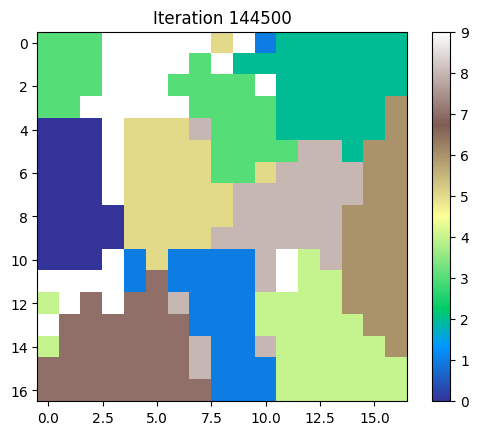

In [300]:
title = ('Iteration ' + str(max_steps))
plt.imshow(label_map, cmap='terrain')
plt.colorbar()
plt.title(title)
plt.show()

In [301]:
print(label_map)
print(som)

[[3 3 3 9 9 9 9 9 5 9 1 2 2 2 2 2 2]
 [3 3 3 9 9 9 9 3 9 2 2 2 2 2 2 2 2]
 [3 3 3 9 9 9 3 3 3 3 9 2 2 2 2 2 2]
 [3 3 9 9 9 9 9 3 3 3 3 2 2 2 2 2 6]
 [0 0 0 9 5 5 5 8 3 3 3 2 2 2 2 2 6]
 [0 0 0 9 5 5 5 5 3 3 3 3 8 8 2 6 6]
 [0 0 0 9 5 5 5 5 3 3 5 8 8 8 8 6 6]
 [0 0 0 9 5 5 5 5 5 8 8 8 8 8 8 6 6]
 [0 0 0 0 5 5 5 5 5 8 8 8 8 8 6 6 6]
 [0 0 0 0 5 5 5 5 8 8 8 8 8 8 6 6 6]
 [0 0 0 9 1 5 1 1 1 1 8 9 4 8 6 6 6]
 [9 9 9 9 1 7 1 1 1 1 8 9 4 4 6 6 6]
 [4 9 7 9 7 7 8 1 1 1 4 4 4 4 6 6 6]
 [9 7 7 7 7 7 7 1 1 1 4 4 4 4 4 6 6]
 [4 7 7 7 7 7 7 8 1 1 8 4 4 4 4 4 6]
 [7 7 7 7 7 7 7 8 1 1 1 4 4 4 4 4 4]
 [7 7 7 7 7 7 7 7 1 1 1 4 4 4 4 4 4]]
[[[ 4.94065646e-324  8.69513551e-001  9.72613252e-001 ...
    1.12804985e+000  2.89280707e-001 -1.56697192e-001]
  [ 4.94065646e-324  3.68126909e-001  7.73412646e-001 ...
    8.51033529e-001  1.43693377e-001 -1.60489165e-001]
  [ 4.94065646e-324 -1.07466200e-001  4.62768609e-001 ...
    8.54174686e-001  9.20060567e-002 -1.59602007e-001]
  ...
  [ 4.94065646e-324  2.63

In [302]:
print(len(som[0]))
print(len(som))

17
17


In [303]:
# print(som[0])
print(som[0][1])

[ 4.94065646e-324  3.68126909e-001  7.73412646e-001  6.11735473e-001
  2.84023501e-002 -5.88859510e-001 -4.07110872e-001 -1.33784503e-001
 -2.35125816e-002  1.15874547e+000  5.82710667e-001 -5.14112939e-001
  8.76698499e-001 -5.33570444e-001 -5.32681652e-001 -1.45729225e-001
 -4.26990163e-002 -2.71131271e-001 -9.01551449e-001 -3.02919051e-001
  1.13220106e+000 -7.68354999e-001 -5.67312800e-001 -1.10527968e-001
 -2.55822255e-002 -7.37083558e-001 -1.14801226e+000  3.75692696e-001
  3.61504953e-001 -8.95543140e-001 -6.39623153e-001 -4.83865933e-002
 -3.61905747e-002 -6.26597437e-001 -1.00279879e+000 -7.30152380e-002
  5.37956109e-001  1.17575233e-001 -4.93016209e-001  4.94065646e-324
 -8.83284167e-002 -4.50581554e-001 -9.45276689e-001 -9.92153145e-001
 -5.27400043e-001  8.35868993e-001  5.10589078e-001 -1.00361129e-001
 -6.17775320e-002 -2.43424244e-001 -2.49174674e-001 -8.42692456e-001
 -7.44529185e-001  7.69147153e-001  8.82792024e-001 -1.64286928e-001
 -1.80864062e-002 -7.34326049e-002

In [304]:
reshaped_data = som[0][0].reshape(1, -1)
# print(som)

# Create a DataFrame
# temp_list = [pd.DataFrame(reshaped_data, columns=range(len(som[0][0])))]
temp_list = []
for i in range(len(som)):
    for j in range(len(som[0])):
        reshaped_data = som[i][j].reshape(1, -1)
        temp = pd.DataFrame(reshaped_data, columns=range(len(som[i][j])))
        temp_list.append(temp)
    
# Display the DataFrame
df_som = pd.concat(temp_list)


In [305]:
import pandas as pd
import numpy as np

df_som = pd.DataFrame(df_som.to_numpy())

df_som

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,4.940656e-324,0.869514,0.972613,0.727708,0.292497,-0.427480,-0.407111,-0.133785,-0.023513,1.616072,...,1.085810,-0.155912,-0.018086,0.378619,1.141357,0.797468,0.840347,1.128050,0.289281,-0.156697
1,4.940656e-324,0.368127,0.773413,0.611735,0.028402,-0.588860,-0.407111,-0.133785,-0.023513,1.158745,...,0.882792,-0.164287,-0.018086,-0.073433,0.844497,0.703176,0.723437,0.851034,0.143693,-0.160489
2,4.940656e-324,-0.107466,0.462769,0.500985,-0.390494,-0.809180,-0.407111,-0.133785,-0.023513,0.751481,...,1.014554,-0.162328,-0.018086,-0.295846,0.376721,0.530444,0.705957,0.854175,0.092006,-0.159602
3,4.940656e-324,-0.079351,0.439460,0.463798,-0.736519,-0.867119,-0.407111,-0.133785,-0.023513,0.327872,...,0.999483,-0.192041,-0.018086,-0.270892,0.186149,0.424840,0.630106,0.868728,0.285072,-0.173056
4,4.940656e-324,-0.252672,0.207081,0.442133,-0.499680,-0.749444,-0.407111,-0.133785,-0.023513,0.282832,...,0.839182,-0.192041,-0.018086,-0.297120,0.030283,0.487881,0.567977,0.723652,0.101210,-0.173056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,4.940656e-324,-0.351143,-1.177893,-2.475931,0.183853,0.123185,-0.382414,-0.133785,-0.023513,-0.647727,...,-0.667657,-0.192041,-0.018086,-0.306294,-1.175791,-2.390387,0.408679,0.050853,-0.517421,-0.173056
285,4.940656e-324,-0.351143,-1.177893,-2.208462,0.147686,-0.215597,-0.394786,-0.133785,-0.023513,-0.647727,...,-0.522075,-0.192041,-0.018086,-0.161020,-1.121535,-2.079806,0.385989,-0.191072,-0.522619,-0.173056
286,4.940656e-324,-0.351143,-1.177893,-2.156559,0.270179,-0.302739,-0.407111,-0.133785,-0.023513,-0.647727,...,-0.394813,-0.192041,-0.018086,-0.071195,-1.092339,-2.006602,0.489407,-0.288103,-0.522619,-0.173056
287,4.940656e-324,-0.351143,-1.177893,-2.074703,0.428483,-0.057325,-0.407111,-0.133785,-0.023513,-0.647727,...,-0.401221,-0.192041,3.182229,0.192367,-1.035484,-1.903815,0.495597,-0.157623,-0.522619,-0.173056


In [306]:
label_map

array([[3, 3, 3, 9, 9, 9, 9, 9, 5, 9, 1, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 9, 9, 9, 9, 3, 9, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 9, 9, 9, 3, 3, 3, 3, 9, 2, 2, 2, 2, 2, 2],
       [3, 3, 9, 9, 9, 9, 9, 3, 3, 3, 3, 2, 2, 2, 2, 2, 6],
       [0, 0, 0, 9, 5, 5, 5, 8, 3, 3, 3, 2, 2, 2, 2, 2, 6],
       [0, 0, 0, 9, 5, 5, 5, 5, 3, 3, 3, 3, 8, 8, 2, 6, 6],
       [0, 0, 0, 9, 5, 5, 5, 5, 3, 3, 5, 8, 8, 8, 8, 6, 6],
       [0, 0, 0, 9, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 6, 6],
       [0, 0, 0, 0, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 6, 6, 6],
       [0, 0, 0, 0, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 6, 6, 6],
       [0, 0, 0, 9, 1, 5, 1, 1, 1, 1, 8, 9, 4, 8, 6, 6, 6],
       [9, 9, 9, 9, 1, 7, 1, 1, 1, 1, 8, 9, 4, 4, 6, 6, 6],
       [4, 9, 7, 9, 7, 7, 8, 1, 1, 1, 4, 4, 4, 4, 6, 6, 6],
       [9, 7, 7, 7, 7, 7, 7, 1, 1, 1, 4, 4, 4, 4, 4, 6, 6],
       [4, 7, 7, 7, 7, 7, 7, 8, 1, 1, 8, 4, 4, 4, 4, 4, 6],
       [7, 7, 7, 7, 7, 7, 7, 8, 1, 1, 1, 4, 4, 4, 4, 4, 4],
       [7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1,

In [307]:
print(som)

[[[ 4.94065646e-324  8.69513551e-001  9.72613252e-001 ...
    1.12804985e+000  2.89280707e-001 -1.56697192e-001]
  [ 4.94065646e-324  3.68126909e-001  7.73412646e-001 ...
    8.51033529e-001  1.43693377e-001 -1.60489165e-001]
  [ 4.94065646e-324 -1.07466200e-001  4.62768609e-001 ...
    8.54174686e-001  9.20060567e-002 -1.59602007e-001]
  ...
  [ 4.94065646e-324  2.63493644e+000  1.88586436e+000 ...
    1.29556076e+000  2.29389575e+000  7.52565696e-001]
  [ 4.94065646e-324  3.76055788e+000  2.03228323e+000 ...
    1.15825290e+000  1.71947877e+000 -5.70451295e-002]
  [ 4.94065646e-324  4.47505094e+000  2.10176946e+000 ...
    1.04472358e+000  1.29962248e+000 -1.61995934e-001]]

 [[ 4.94065646e-324  1.17136594e+000  1.22707173e+000 ...
    7.19266672e-001  1.58569738e-002 -1.73055805e-001]
  [ 4.94065646e-324  4.22074322e-001  8.01537149e-001 ...
    5.33910173e-001 -2.37328793e-001 -1.62463613e-001]
  [ 4.94065646e-324 -5.30801592e-003  6.71368732e-001 ...
    5.96902129e-001 -4.5358826

In [308]:
print(som[1][0])
df_som.loc[17]

[ 4.94065646e-324  1.17136594e+000  1.22707173e+000  7.71795580e-001
  1.92335570e-001 -5.20613473e-001 -4.07110853e-001 -1.33784503e-001
 -2.35125816e-002  1.76642542e+000  5.74101783e-001 -8.39910374e-001
  8.53491929e-001 -2.95542286e-001 -5.29045263e-001 -1.45729225e-001
 -4.26990163e-002 -1.72813901e-001 -1.22823393e+000 -3.22491633e-001
  1.17316278e+000 -5.79207168e-001 -5.63214240e-001 -1.10527968e-001
 -2.55822255e-002 -7.31907866e-001 -1.08287157e+000  6.75271839e-001
  4.84363108e-001 -8.39057384e-001 -6.08177119e-001 -4.83865933e-002
 -3.61905747e-002 -6.20464925e-001 -9.72276604e-001 -5.71201641e-002
  5.18213928e-001  2.27435419e-001 -4.07784983e-001  4.94065646e-324
 -8.83284167e-002 -4.37140912e-001 -9.51663538e-001 -1.01664354e+000
 -5.73727436e-001  9.14410558e-001  6.66342599e-001 -1.00361129e-001
 -6.17775320e-002  7.70646036e-002 -9.16370211e-003 -1.05850983e+000
 -6.98461217e-001  8.00692588e-001  9.52430112e-001 -1.92040712e-001
 -1.80864062e-002  6.72109206e-001

0     4.940656e-324
1      1.171366e+00
2      1.227072e+00
3      7.717956e-01
4      1.923356e-01
          ...      
59     7.945225e-01
60     7.011780e-01
61     7.192667e-01
62     1.585697e-02
63    -1.730558e-01
Name: 17, Length: 64, dtype: float64

In [309]:
print(len(label_map[0]))

17


In [310]:
print(len(df_som))

289


In [311]:
temp = label_map.flatten()
print(temp)

df_som['Class'] = temp
df_som

[3 3 3 9 9 9 9 9 5 9 1 2 2 2 2 2 2 3 3 3 9 9 9 9 3 9 2 2 2 2 2 2 2 2 3 3 3
 9 9 9 3 3 3 3 9 2 2 2 2 2 2 3 3 9 9 9 9 9 3 3 3 3 2 2 2 2 2 6 0 0 0 9 5 5
 5 8 3 3 3 2 2 2 2 2 6 0 0 0 9 5 5 5 5 3 3 3 3 8 8 2 6 6 0 0 0 9 5 5 5 5 3
 3 5 8 8 8 8 6 6 0 0 0 9 5 5 5 5 5 8 8 8 8 8 8 6 6 0 0 0 0 5 5 5 5 5 8 8 8
 8 8 6 6 6 0 0 0 0 5 5 5 5 8 8 8 8 8 8 6 6 6 0 0 0 9 1 5 1 1 1 1 8 9 4 8 6
 6 6 9 9 9 9 1 7 1 1 1 1 8 9 4 4 6 6 6 4 9 7 9 7 7 8 1 1 1 4 4 4 4 6 6 6 9
 7 7 7 7 7 7 1 1 1 4 4 4 4 4 6 6 4 7 7 7 7 7 7 8 1 1 8 4 4 4 4 4 6 7 7 7 7
 7 7 7 8 1 1 1 4 4 4 4 4 4 7 7 7 7 7 7 7 7 1 1 1 4 4 4 4 4 4]


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,Class
0,4.940656e-324,0.869514,0.972613,0.727708,0.292497,-0.427480,-0.407111,-0.133785,-0.023513,1.616072,...,-0.155912,-0.018086,0.378619,1.141357,0.797468,0.840347,1.128050,0.289281,-0.156697,3
1,4.940656e-324,0.368127,0.773413,0.611735,0.028402,-0.588860,-0.407111,-0.133785,-0.023513,1.158745,...,-0.164287,-0.018086,-0.073433,0.844497,0.703176,0.723437,0.851034,0.143693,-0.160489,3
2,4.940656e-324,-0.107466,0.462769,0.500985,-0.390494,-0.809180,-0.407111,-0.133785,-0.023513,0.751481,...,-0.162328,-0.018086,-0.295846,0.376721,0.530444,0.705957,0.854175,0.092006,-0.159602,3
3,4.940656e-324,-0.079351,0.439460,0.463798,-0.736519,-0.867119,-0.407111,-0.133785,-0.023513,0.327872,...,-0.192041,-0.018086,-0.270892,0.186149,0.424840,0.630106,0.868728,0.285072,-0.173056,9
4,4.940656e-324,-0.252672,0.207081,0.442133,-0.499680,-0.749444,-0.407111,-0.133785,-0.023513,0.282832,...,-0.192041,-0.018086,-0.297120,0.030283,0.487881,0.567977,0.723652,0.101210,-0.173056,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,4.940656e-324,-0.351143,-1.177893,-2.475931,0.183853,0.123185,-0.382414,-0.133785,-0.023513,-0.647727,...,-0.192041,-0.018086,-0.306294,-1.175791,-2.390387,0.408679,0.050853,-0.517421,-0.173056,4
285,4.940656e-324,-0.351143,-1.177893,-2.208462,0.147686,-0.215597,-0.394786,-0.133785,-0.023513,-0.647727,...,-0.192041,-0.018086,-0.161020,-1.121535,-2.079806,0.385989,-0.191072,-0.522619,-0.173056,4
286,4.940656e-324,-0.351143,-1.177893,-2.156559,0.270179,-0.302739,-0.407111,-0.133785,-0.023513,-0.647727,...,-0.192041,-0.018086,-0.071195,-1.092339,-2.006602,0.489407,-0.288103,-0.522619,-0.173056,4
287,4.940656e-324,-0.351143,-1.177893,-2.074703,0.428483,-0.057325,-0.407111,-0.133785,-0.023513,-0.647727,...,-0.192041,3.182229,0.192367,-1.035484,-1.903815,0.495597,-0.157623,-0.522619,-0.173056,4


In [312]:
print(label_map[0][0])

3


In [313]:
# df.to_csv('som.csv')

# KMeans

In [314]:
#Basic imports
import numpy as np
import pandas as pd

#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

#plotly imports
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [315]:
#Initialize our model
kmeans = KMeans(n_clusters=10)

In [316]:
#Fit our model
kmeans.fit(df_som)

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



KMeans(n_clusters=10)

In [320]:
#Find which cluster each data-point belongs to
clusters = kmeans.predict(df_som)
#Add the cluster vector to our DataFrame, X
df_som["Cluster"] = clusters

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [321]:
# kmeans.predict(df[0])

In [322]:
plotX = df_som
#PCA with one principal component
pca_1d = PCA(n_components=1)

#PCA with two principal components
pca_2d = PCA(n_components=2)

#PCA with three principal components
pca_3d = PCA(n_components=3)
#This DataFrame holds that single principal component mentioned above
PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#And this DataFrame contains three principal components that will aid us
#in visualizing our clusters in 3-D
PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotX.drop(["Cluster"], axis=1)))
PCs_1d.columns = ["PC1_1d"]

#"PC1_2d" means: 'The first principal component of the components created for 2-D visualization, by PCA.'
#And "PC2_2d" means: 'The second principal component of the components created for 2-D visualization, by PCA.'
PCs_2d.columns = ["PC1_2d", "PC2_2d"]

PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
plotX = pd.concat([plotX,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')
plotX["dummy"] = 0
#Note that all of the DataFrames below are sub-DataFrames of 'plotX'.
#This is because we intend to plot the values contained within each of these DataFrames.

cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]
cluster2 = plotX[plotX["Cluster"] == 2]
cluster3 = plotX[plotX["Cluster"] == 3]
cluster4 = plotX[plotX["Cluster"] == 4]
cluster5 = plotX[plotX["Cluster"] == 5]
cluster6 = plotX[plotX["Cluster"] == 6]
cluster7 = plotX[plotX["Cluster"] == 7]
cluster8 = plotX[plotX["Cluster"] == 8]
cluster9 = plotX[plotX["Cluster"] == 9]

#This is needed so we can display plotly plots properly
init_notebook_mode(connected=True)

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_2d"],
                    y = cluster2["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

trace4 = go.Scatter(
                    x = cluster3["PC1_2d"],
                    y = cluster3["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(255, 0, 0, 0.8)'),
                    text = None)

trace5 = go.Scatter(
                    x = cluster4["PC1_2d"],
                    y = cluster4["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 4",
                    marker = dict(color = 'rgba(0, 255, 0, 0.8)'),
                    text = None)

trace6 = go.Scatter(
                    x = cluster5["PC1_2d"],
                    y = cluster5["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 5",
                    marker = dict(color = 'rgba(0, 0, 255, 0.8)'),
                    text = None)

trace7 = go.Scatter(
                    x = cluster6["PC1_2d"],
                    y = cluster6["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 6",
                    marker = dict(color = 'rgba(255, 255, 0, 0.8)'),
                    text = None)


trace8 = go.Scatter(
                    x = cluster6["PC1_2d"],
                    y = cluster6["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 7",
                    marker = dict(color = 'rgba(100, 255, 0, 0.8)'),
                    text = None)

trace9 = go.Scatter(
                    x = cluster6["PC1_2d"],
                    y = cluster6["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 8",
                    marker = dict(color = 'rgba(255, 255, 59, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/py

In [241]:
#Add the cluster vector to our DataFrame, X
df_som["Cluster"] = clusters

In [242]:
# accuracy = 0
# for i in range(len(df)):
#     if df.loc[i]['Cluster'] == df.loc[i]['Label']:
#         accuracy += 1
# print(accuracy / len(df))

In [245]:
print(kmeans.inertia_/len(df_som)) # sklearn built in sse metric

19.69547957999361


In [247]:
# silhoutte score 
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# sample = pd.DataFrame(np.array(X.sample(5000)))

for n_clusters in range(4, 12):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_som)
    centers = clusterer.cluster_centers_
    # print('here')
    score = silhouette_score(df_som, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
# print(silhoutte_score(X, ))

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/py

For n_clusters = 4, silhouette score is 0.26854168681117996)
For n_clusters = 5, silhouette score is 0.26411803204877965)
For n_clusters = 6, silhouette score is 0.278628350026005)
For n_clusters = 7, silhouette score is 0.28937941657907856)


/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/ryandpark/miniconda3/envs/py311/lib/py

For n_clusters = 8, silhouette score is 0.3019278862883225)


/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/ryandpark/miniconda3/envs/py311/lib/py

For n_clusters = 9, silhouette score is 0.31833826227593076)
For n_clusters = 10, silhouette score is 0.3311073255139434)
For n_clusters = 11, silhouette score is 0.332684004977572)


/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [181]:
df_som

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,Class,Cluster
0,4.940656e-324,0.869514,0.972613,0.727708,0.292497,-0.427480,-0.407111,-0.133785,-0.023513,1.616072,...,-0.018086,0.378619,1.141357,0.797468,0.840347,1.128050,0.289281,-0.156697,3,2
1,4.940656e-324,0.368127,0.773413,0.611735,0.028402,-0.588860,-0.407111,-0.133785,-0.023513,1.158745,...,-0.018086,-0.073433,0.844497,0.703176,0.723437,0.851034,0.143693,-0.160489,3,2
2,4.940656e-324,-0.107466,0.462769,0.500985,-0.390494,-0.809180,-0.407111,-0.133785,-0.023513,0.751481,...,-0.018086,-0.295846,0.376721,0.530444,0.705957,0.854175,0.092006,-0.159602,3,2
3,4.940656e-324,-0.079351,0.439460,0.463798,-0.736519,-0.867119,-0.407111,-0.133785,-0.023513,0.327872,...,-0.018086,-0.270892,0.186149,0.424840,0.630106,0.868728,0.285072,-0.173056,9,9
4,4.940656e-324,-0.252672,0.207081,0.442133,-0.499680,-0.749444,-0.407111,-0.133785,-0.023513,0.282832,...,-0.018086,-0.297120,0.030283,0.487881,0.567977,0.723652,0.101210,-0.173056,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,4.940656e-324,-0.351143,-1.177893,-2.475931,0.183853,0.123185,-0.382414,-0.133785,-0.023513,-0.647727,...,-0.018086,-0.306294,-1.175791,-2.390387,0.408679,0.050853,-0.517421,-0.173056,4,7
285,4.940656e-324,-0.351143,-1.177893,-2.208462,0.147686,-0.215597,-0.394786,-0.133785,-0.023513,-0.647727,...,-0.018086,-0.161020,-1.121535,-2.079806,0.385989,-0.191072,-0.522619,-0.173056,4,7
286,4.940656e-324,-0.351143,-1.177893,-2.156559,0.270179,-0.302739,-0.407111,-0.133785,-0.023513,-0.647727,...,-0.018086,-0.071195,-1.092339,-2.006602,0.489407,-0.288103,-0.522619,-0.173056,4,7
287,4.940656e-324,-0.351143,-1.177893,-2.074703,0.428483,-0.057325,-0.407111,-0.133785,-0.023513,-0.647727,...,3.182229,0.192367,-1.035484,-1.903815,0.495597,-0.157623,-0.522619,-0.173056,4,5


In [183]:
accuracy = 0
for i in range(len(df_som)):
    if df_som.loc[i]['Cluster'] == df_som.loc[i]['Class']:
        accuracy += 1
print(accuracy / len(df_som))

0.27335640138408307


In [189]:
filtered_df = df_som[df_som['Cluster'] == 1]
filtered_df

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,Class,Cluster
128,4.940656e-324,1.919627,1.324311,0.293805,-0.111462,0.355802,0.212765,-0.133367,-0.023513,0.950013,...,-0.018086,2.070701,1.549628,0.165944,-1.287784,-0.979075,-0.522619,-0.173056,8,1
145,4.940656e-324,0.504936,0.984440,0.314245,-0.111592,0.122811,-0.209595,-0.132999,-0.023513,0.725890,...,-0.018086,0.323837,1.174093,0.475266,-1.025388,-1.056680,-0.522619,-0.173056,8,1
161,4.940656e-324,0.083632,0.722069,0.320380,0.054213,0.076180,-0.265345,-0.133785,-0.023513,0.137864,...,-0.018086,-0.119784,0.701386,0.352132,-0.514706,-0.779479,-0.511704,-0.173056,8,1
162,4.940656e-324,-0.098704,0.430422,0.412912,0.160117,0.021982,-0.275159,-0.133785,-0.023513,0.174799,...,-0.018086,-0.131686,0.501482,0.498223,-0.273529,-0.878205,-0.514012,-0.173056,8,1
180,4.940656e-324,-0.323741,-0.174675,0.265666,0.516000,0.397291,-0.057980,-0.133785,-0.023513,0.067881,...,-0.018086,-0.253016,-0.135755,0.473137,-0.401545,-0.836874,-0.513547,-0.173056,8,1
181,4.940656e-324,-0.300584,-0.288942,-0.057157,0.172551,0.477981,0.122675,-0.107373,-0.023513,0.080471,...,-0.018086,-0.242796,-0.290933,0.181655,-1.148920,-0.991939,-0.522619,-0.173056,9,1
182,4.940656e-324,-0.293226,-0.239891,0.032006,-0.381047,-0.030572,0.138544,-0.028067,-0.023513,0.037783,...,-0.018086,-0.235310,-0.258632,0.236156,-1.520444,-0.889881,-0.385617,-0.173056,4,1
192,4.940656e-324,-0.308382,-0.509779,0.269769,0.540828,0.077584,-0.358041,-0.133785,-0.023513,-0.093856,...,-0.018086,-0.306294,-0.398325,0.238472,-0.783040,-0.698862,-0.518157,-0.173056,7,1
198,4.940656e-324,-0.351143,-0.756630,-0.355614,0.468263,0.469727,0.358047,-0.073359,-0.023513,-0.208119,...,-0.018086,-0.306294,-0.777373,0.052608,-0.772106,-1.021716,-0.522513,-0.173056,9,1
205,4.940656e-324,-0.351143,-0.911013,-0.907698,0.294531,1.123292,1.607397,0.042075,-0.023513,-0.569422,...,-0.018086,-0.306294,-0.948526,-0.353164,-0.428396,-0.950910,-0.522619,-0.173056,9,1


In [190]:
filtered_df['Class'].value_counts()

Class
7    25
8     8
9     4
4     1
Name: count, dtype: int64

In [191]:
filtered_df = df_som[df_som['Cluster'] == 2]
filtered_df['Class'].value_counts()

Class
3    29
5    27
2     2
Name: count, dtype: int64

In [192]:
filtered_df = df_som[df_som['Cluster'] == 3]
filtered_df['Class'].value_counts()

Class
7    6
4    2
9    1
Name: count, dtype: int64

In [193]:
filtered_df = df_som[df_som['Cluster'] == 4]
filtered_df['Class'].value_counts()

Class
2    29
1     1
Name: count, dtype: int64

In [187]:
df_som['Cluster'].value_counts()

Cluster
2    58
9    50
1    38
4    30
6    26
8    26
0    23
7    23
3     9
5     6
Name: count, dtype: int64

In [194]:
filtered_df = df_som[df_som['Cluster'] == 5]
filtered_df['Class'].value_counts()

Class
4    5
6    1
Name: count, dtype: int64

# KMeans++

In [283]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Create synthetic data for demonstration
# X, _ = make_blobs(n_samples=300, centers=4, random_state=42)
# temp = np.array(df)

# Use KMeans++ initialization in KMeans clustering
kmeans_pp = KMeans(n_clusters=10, init='k-means++', random_state=0)
kmeans_pp.fit(df_som)

# # Plot the results
# plt.scatter(temp[:, 0], temp[:, 1], c=kmeans_pp.labels_, cmap='viridis', alpha=0.7)
# plt.scatter(kmeans_pp.cluster_centers_[:, 0], kmeans_pp.cluster_centers_[:, 1], marker='X', s=200, c='red')
# plt.title('KMeans++ Clustering')
# plt.show()

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



KMeans(n_clusters=10, random_state=0)

In [284]:
predictions = kmeans_pp.predict(df)


/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but KMeans was fitted without feature names

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [286]:
(kmeans_pp.inertia_/len(df_som))

19.795416241288002

In [287]:
# silhoutte score 
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# sample = pd.DataFrame(np.array(X.sample(5000)))

for n_clusters in range(4, 12):
    kmeans_pp = KMeans(n_clusters=10, init='k-means++')
    preds = clusterer.fit_predict(df_som)
    centers = clusterer.cluster_centers_
    # print('here')
    score = silhouette_score(df_som, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
# print(silhoutte_score(X, ))

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/py

For n_clusters = 4, silhouette score is 0.28978654580346896)


/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/ryandpark/miniconda3/envs/py311/lib/py

For n_clusters = 5, silhouette score is 0.26639241281514575)


/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/ryandpark/miniconda3/envs/py311/lib/py

For n_clusters = 6, silhouette score is 0.2785092283663183)
For n_clusters = 7, silhouette score is 0.28203834583242143)
For n_clusters = 8, silhouette score is 0.26897842954912865)


/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/py

For n_clusters = 9, silhouette score is 0.27436585404504094)
For n_clusters = 10, silhouette score is 0.2792933769845267)
For n_clusters = 11, silhouette score is 0.2852459226583942)


/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:757: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:595: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:604: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/Users/ryandpark/miniconda3/envs/py311/lib/py

In [ ]:
accuracy = 0
for i in range(len(df)):
    if df.loc[i]['Cluster'] == df.loc[i]['Class']:
        accuracy += 1
print(accuracy / len(df))